# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [24]:
from os.path import join, isfile
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns

%pylab inline

sns.set_palette('hls')
sns.set_context("notebook")

DATA_FOLDER = join('..', '..', 'ADA2017-Tutorials', '02 - Intro to Pandas', 'Data')
DATA_EBOLA = join(DATA_FOLDER, 'ebola')
DATA_TITANIC = DATA_FOLDER

Populating the interactive namespace from numpy and matplotlib


## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average* per year of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

## 1.1 Look at the data 

The reporting method is different in each country. Therefore we have to build different parsers. In our case, we are interested in the **daily average** per year of new **cases** and **death**. The dataset contains a lot of feilds that are useless for us and that we will drop.
Note that:

* We assume that death in health workers are part of total new death/cases (e.i. total death number = patient death + HW death).
* We assurme that if a value is missing, it means that there is no change recorded

## 1.2 Guinea
Let's first read all csv files and concatenate the datas. We can directly parse the `Date` as a date entry. We fill the missing values (NaN) with 0 since it probably means that no changes were reported. The column `Total` contain the total values for each `Description` (sum of all cities). After parsing we must take a look at the duplicates to see if we have multiple entries for the same tuple (`Date`, `Description`).

In [ ]:
# Read all files and concatenate them
guinea_path = join(DATA_EBOLA, 'guinea_data')
guinea_files = [join(guinea_path, f) for f in listdir(guinea_path) if isfile(join(guinea_path, f))]

r=[]
for i in range(len(guinea_files)):
    r.append(pd.read_csv(guinea_files[i], usecols=['Description', 'Totals', 'Date'], 
                         parse_dates=['Date']).fillna(0))
    
r = pd.concat(r)
print('Contains duplicates:', any(r.duplicated(subset=['Date', 'Description'])) )

Since no duplicates were found we can pivot the table and keep the `Date` as index and `Totals` in `Description` column

In [ ]:
r = r.pivot_table(index='Date', columns='Description', values='Totals', aggfunc='max').fillna(0)
r.head()

As said above, most of the columns are useless in our case. Let's display the entries to choose the columns that contains meaningfull values.

In [ ]:
r.columns

All fields containing the overall (total) cases/death will be dropes. We will only keep `New cases of confirmed`, `New cases of probables`, `New cases of suspects`, `New deaths registered`, `New deaths registered today (confirmed)`, `New deaths registered today (probables)` and `New deaths registered today (suspects)` since they are more likely to contain meaningfull information.

In [ ]:
r[['New cases of confirmed', 'New cases of probables', 'New cases of suspects', 'New deaths registered', 
   'New deaths registered today (confirmed)', 'New deaths registered today (probables)', 
   'New deaths registered today (suspects)']].head()

Note that some of the fields were not properly parsed (type is object instead of int). Therefore we will apply **to_numeric** funtion to cast them to numbers allowing us to use basic mathematical operation.

We create new fields that will be used to merge all the data (for all the countries). `n_case` contains the new cases, `n_case_un` the probable/suspected cases, `n_death` the new registred deaths and `n_death_un` the deaths suspected/probable

In [ ]:
r['n_case'] = pd.to_numeric(r['New cases of confirmed'])
r['n_case_un'] = pd.to_numeric(r['New cases of probables']) + pd.to_numeric(r['New cases of suspects'])
r['n_death'] = pd.to_numeric(r['New deaths registered']) + pd.to_numeric(r['New deaths registered today (confirmed)'])
r['n_death_un'] = pd.to_numeric(r['New deaths registered today (probables)']) + pd.to_numeric(r['New deaths registered today (suspects)'])
r['country'] = ['guinea']*len(r['n_case'])
guinea_res = r[['country', 'n_case', 'n_case_un', 'n_death', 'n_death_un']]
guinea_res.head()

## 1.3 Liberia
Almost the same as Guinea data. We directly parse the `Date` as a date entry. We fill the missing values with 0 since it probably means that no changes were reported. The column `National` contain the total values for each `Variable` (sum of all cities). After parsing we take a look at the duplicates to see if we have multiple entries for the same tuple (`Date`, `Variable`).

In [ ]:
# Read all files and concatenate them
liberia_path = join(DATA_EBOLA, 'liberia_data')
liberia_files = [join(liberia_path, f) for f in listdir(liberia_path) if isfile(join(liberia_path, f))]

r_l=[]
for i in range(len(liberia_files)): 
    r_l.append(pd.read_csv(liberia_files[i], usecols=['Date', 'Variable', 'National'], 
                         parse_dates=['Date']).fillna(0))
    
r_l = pd.concat(r_l)
print('Contains duplicates:', any(r_l.duplicated(subset=['Date', 'Variable'])))

The data contain duplicates. We need to handle them. Let's take a look at the duplicates.

In [ ]:
r_l[r_l.duplicated(subset=['Date', 'Variable'])]

We can see that those fields are not relevant. Therefore we can either drop them or merge them. We chose to merge them, using max function, to avoid losing data and to pivot the table as we did for the Guinea data.

In [ ]:
r_l = r_l.pivot_table(index='Date', columns='Variable', values='National', aggfunc=max).fillna(0)
r_l.head()

Most of the column are useless in our case. Let's display the entries to choose the columns that contains meaningfull values.

In [ ]:
r_l.columns

All fields containing the overall (total) cases/death will be dropes. We will only keep `'New Case/s (Probable)`, `New Case/s (Suspected)`, `New case/s (confirmed)` and `Newly reported deaths)`.

In [ ]:
r_l[['New Case/s (Probable)', 'New Case/s (Suspected)', 'New case/s (confirmed)', 'Newly reported deaths']].head()

We create the new fields to match the data schema that we choosed.

In [ ]:
r_l['n_case'] = r_l['New case/s (confirmed)']
r_l['n_case_un'] = r_l['New Case/s (Suspected)'] + r_l['New Case/s (Probable)']
r_l['n_death'] = r_l['Newly reported deaths']
r_l['country'] = ['liberia']*len(r_l['n_case'])
liberia_res = r_l[['country', 'n_case', 'n_case_un', 'n_death']]
liberia_res.head()

## 1.4 Sierra Leon
Same logic as before. We directly parse the `date` as a date entry. We fill the missing values with 0 since it probably means that no changes were reported. The column `National` contain the total values for each description (sum of all cities). After parsing we take a look at the duplicates to see if we have multiple entries for the same tuple (`date`, `variable`).

In [ ]:
# Read all files and concatenate them
sl_path = join(DATA_EBOLA, 'sl_data')
sl_files = [join(sl_path, f) for f in listdir(sl_path) if isfile(join(sl_path, f))]

r_sl=[]
for i in range(len(sl_files)): 
    r_sl.append(pd.read_csv(sl_files[i], usecols=['date', 'variable', 'National'], 
                         parse_dates=['date']).fillna(0))
    
r_sl = pd.concat(r_sl)
print('Contains duplicates:', any(r_sl.duplicated(subset=['date', 'variable'])))

The data contain duplicates, so let's look at the duplicates

In [ ]:
r_sl[r_sl.duplicated(subset=['date', 'variable'])]

Those fields are not relevant. Therefore we can either drop them or merge them as we already did for the previous data. We also choose to merge them using max function to avoid data loss.

In [ ]:
r_sl = r_sl.pivot_table(index='date', columns='variable', values='National', aggfunc=max).fillna(0)
r_sl.head()

Most of the column are useless in our case. Let's display the entries to choose the columns that contains meaningfull values.

In [16]:
r_sl.columns

Index(['cfr', 'contacts_followed', 'contacts_healthy', 'contacts_ill',
       'contacts_not_seen', 'cum_completed_contacts', 'cum_confirmed',
       'cum_contacts', 'cum_noncase', 'cum_probable', 'cum_suspected',
       'death_confirmed', 'death_probable', 'death_suspected',
       'etc_cum_admission', 'etc_cum_deaths', 'etc_cum_discharges',
       'etc_currently_admitted', 'etc_new_admission', 'etc_new_deaths',
       'etc_new_discharges', 'negative_corpse', 'new_completed_contacts',
       'new_confirmed', 'new_contacts', 'new_negative', 'new_noncase',
       'new_positive', 'new_probable', 'new_samples', 'new_suspected',
       'pending', 'percent_seen', 'population', 'positive_corpse',
       'repeat_samples', 'total_lab_samples'],
      dtype='object', name='variable')

All fields containing the overall (cumulative) of cases/death will be dropes. We will only keep `'new_confirmed`, `new_probable`, `new_suspected` and `death_confirmed` since they are more likely to contain the information we want.

Note that `death_confirmed` migth contain the overall value of death. Let's take a look at it.

In [17]:
r_sl[['new_confirmed', 'new_probable', 'new_suspected', 'death_confirmed']].head(16)

variable,new_confirmed,new_probable,new_suspected,death_confirmed
date,,,,
2014-08-12,11,1,10,264
2014-08-13,15,1,3,273
2014-08-14,13,2,0,280
2014-08-15,10,1,6,287
2014-08-16,18,0,3,297
2014-08-17,2,0,1,305
2014-08-18,5,15,40,312
2014-08-19,9,3,16,320
2014-08-20,4,0,1,322


Indeed, `death_confirmed` contains the overall number of death. Moreover it also contains 0 since data were probably missing. Let's take also a look at those data with missing entries

In [18]:
r_sl.loc[r_sl['death_confirmed']==0, ['new_confirmed', 'new_probable', 'new_suspected', 'death_confirmed']]

variable,new_confirmed,new_probable,new_suspected,death_confirmed
date,,,,
2014-08-26,0,0,0,0
2014-08-29,0,0,0,0
2014-09-05,0,0,0,0
2014-09-12,0,0,0,0
2014-11-14,0,0,0,0
2014-11-19,0,0,0,0
2014-12-13,0,0,0,0


Since all fields are empty we can drop thoses entries. Afterward we can estimate the number of new death as the difference of total registred deaths between two days. Note that for day 1 (first entry in the table) we will not be able to estimate the amount of new deaths. Therefore we chose to put it to 0.

In [19]:
r_sl.drop(r_sl.loc[r_sl['death_confirmed']==0].index, inplace=True)
r_sl['new_death'] = pd.to_numeric(r_sl['death_confirmed']).diff().fillna(0)

Finally, we create the new fields to match the data schema that we choosed.

In [20]:
r_sl['n_case'] = pd.to_numeric(r_sl['new_confirmed'])
r_sl['n_case_un'] = pd.to_numeric(r_sl['new_probable'] + r_sl['new_suspected'])
r_sl['n_death'] = pd.to_numeric(r_sl['new_death'])
r_sl['country'] = ['sl']*len(r_sl['n_case'])
sl_res = r_sl[['country', 'n_case', 'n_case_un', 'n_death']]
sl_res.head()

variable,country,n_case,n_case_un,n_death
date,,,,
2014-08-12,sl,11.0,110.0,0.0
2014-08-13,sl,15.0,13.0,9.0
2014-08-14,sl,13.0,20.0,7.0
2014-08-15,sl,10.0,16.0,7.0
2014-08-16,sl,18.0,3.0,10.0


## 1.5 Results


Now that all data have the same structure we can concatenate them

In [21]:
r = pd.concat([guinea_res, liberia_res, sl_res]).fillna(0)

We can also look at the evolution of number of cases and death for each country.

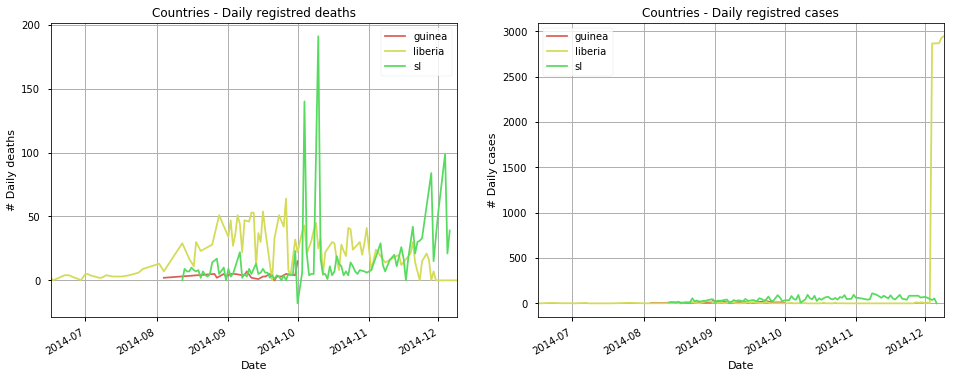

In [25]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(16,6))
for label, df in r.groupby('country'):
    df.plot(y='n_death', ax=ax, label=label)
for label, df in r.groupby('country'):
    df.plot(y='n_case', ax=ax2, label=label)
ax.grid(); ax2.grid()
ax.set_xlabel('Date'); ax2.set_xlabel('Date')
ax.set_ylabel('# Daily deaths'); ax2.set_ylabel('# Daily cases')
ax.set_title('Countries - Daily registred deaths'); ax2.set_title('Countries - Daily registred cases')
plt.legend()

### 1.5.1. Negative number of death
Note that for Sierra Leon (sl), there is a number of registred death negative around early october. This is, of course, not due to the fact that people resuscitated. Here is a more detailed view of the problem

In [26]:
r_sl.iloc[40:50][['death_confirmed', 'new_death']]

variable,death_confirmed,new_death
date,,
2014-09-26,513,0.0
2014-09-27,518,5.0
2014-09-28,522,4.0
2014-09-29,527,5.0
2014-09-30,550,23.0
2014-10-01,532,-18.0
2014-10-03,538,6.0
2014-10-04,678,140.0
2014-10-05,699,21.0


In [27]:
r.loc[r['n_death'] < 0, 'n_death'] = 0
###### TODO ############# fix 0 and 5

The problem appears between the 2014-09-30 and 2014-10-01 where the number of death decreased. The problem seems to be a typo (550 typed instead of 530) or a wrong estimation of number of death in a specific city. In both case we are not able to determine the real value of this field so we put 2014-09-30 to **0** (no changes) and 2014-10-01 to **5** (532-527) to be consistant with data.

### 1.5.2. Liberia sudden cases peak
We can also see a huge peek at the end for the Liberia. it could be a sudden increase of registred cases but there is no correlation with the number of death.

In [28]:
r_l.loc['2014-12-01':'2014-12-09'][['Total probable cases', 'New Case/s (Probable)',  
                                    'Total suspected cases', 'New Case/s (Suspected)', 
                                    'Total confirmed cases', 'New case/s (confirmed)', 'Newly reported deaths']]

Variable,Total probable cases,New Case/s (Probable),Total suspected cases,New Case/s (Suspected),Total confirmed cases,New case/s (confirmed),Newly reported deaths
Date,,,,,,,
2014-12-01,1793.0,9.0,3059.0,25.0,2823.0,1.0,0.0
2014-12-02,1809.0,10.0,3057.0,18.0,2824.0,9.0,0.0
2014-12-03,1814.0,0.0,3075.0,0.0,2830.0,0.0,0.0
2014-12-04,0.0,1800.0,0.0,3054.0,0.0,2867.0,0.0
2014-12-05,0.0,1808.0,0.0,3056.0,0.0,2867.0,0.0
2014-12-06,0.0,1810.0,0.0,3056.0,0.0,2869.0,0.0
2014-12-07,0.0,1829.0,0.0,3067.0,0.0,2869.0,0.0
2014-12-08,0.0,1805.0,0.0,3054.0,0.0,2927.0,0.0
2014-12-09,0.0,1801.0,0.0,3050.0,0.0,2946.0,0.0


In [29]:
r.drop(r.loc[np.logical_and(r.index >= '2014-12-04', r['country']=='liberia')].index, inplace=True)

### 1.5.3. Final plot and results (cleared)

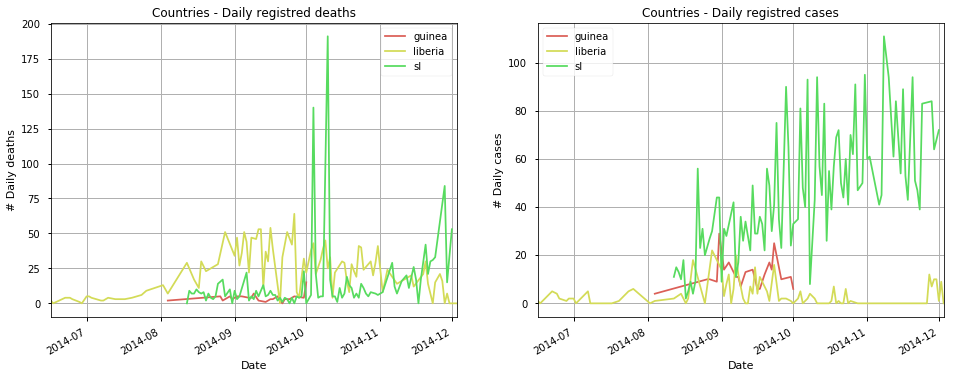

In [30]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(16,6))
for label, df in r.groupby('country'):
    df.plot(y='n_death', ax=ax, label=label)
for label, df in r.groupby('country'):
    df.plot(y='n_case', ax=ax2, label=label)
ax.grid(); ax2.grid()
ax.set_xlabel('Date'); ax2.set_xlabel('Date')
ax.set_ylabel('# Daily deaths'); ax2.set_ylabel('# Daily cases')
ax.set_title('Countries - Daily registred deaths'); ax2.set_title('Countries - Daily registred cases')
plt.legend()


We can finally compute the number of death and new cases. We add in the table the `n_case_tot` and `n_death_tot` to take into account the probable cases/deaths. Each column is expressed as the **daily average** case/death **per year**

We can see on the next graph that the number of death per day (`n_death`) is more important in Liberia and Sierra Leon . If we consider the probable cases `n_case_tot`, the are more cases of ebola in Sierra Leon.

In [31]:
r['n_case_tot'] = r['n_case'] +  r['n_case_un']
r['n_death_tot'] = r['n_death'] +  r['n_death_un']

COUNTRIES = ['guinea', 'liberia', 'sl']
ds = [(r[r['country']==COUNTRY].index[-1]-r[r['country']==COUNTRY].index[0]).days for COUNTRY in COUNTRIES]
print('Days spans: {}'.format(ds))
r.groupby('country').sum().divide(ds, axis=0)

Days spans: [58, 170, 111]


,n_case,n_case_un,n_death,n_death_un,n_case_tot,n_death_tot
country,,,,,,
guinea,4.758621,3.465517,1.534483,0.0,8.224138,1.534483
liberia,1.852941,19.376471,11.988235,0.0,21.229412,11.988235
sl,38.621622,31.981982,11.738739,0.0,70.603604,11.738739


## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [32]:
# Write your answer here

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [ ]:
from IPython.core.display import HTML
# HTML(filename=DATA_FOLDER+'/titanic.html')

For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

## 3.1 Read data

In [33]:
# Write your answer here
df = pd.read_excel(join(DATA_TITANIC, 'titanic.xls'),  
                   converters={'pclass': np.int, 'survived': np.int, 'age': np.float})
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


Let's talk about how data are organized cloumn by column 
* `pclass`: As describe in titanic.html, this field can take 1,2,3 as value. It can be categorical. 
* `survived`: Binary class, can also be set as categorical (0, 1)
* `name`: Passenger name. Simple string value. No categorical
* `sex`: Sex of the personne. Can be categorical (female, male)
* `age`: Age of the passenger, should be in range 0-100 (normally) and be an number. No categorical
* `slbsp`/`parch`: Familly related field. Should be an positive integer. No categorical
* `ticket`: Id of the ticket. No categorical
* `fare`: Fare, expressed in British pound. Range 0 to ... a lot! No categorical
* `cabin`: Contains the number and the floor.
    * `floor`: Letter indicate the floor number. Categorical
* `embarked`: Embarcation location. Categorical Cherbourg (C), Queenstown (Q), Southampton (S)
* `boat`: boat id number
* `body`: Body id number
* `home.dest`: Home and final destination of the passenger

Note that we do not have to control each column. We need check the data for `pclass`, `survived`, `sex`, `age`, `cabin`, `embarked`. If ranges was no specified it means that the values can either be a string (no limit) either be a mix between numbers and strings (`cabin` for example).

## 3.2 Clean data

* `pclass`: First we check it contains indeed only 3 values (1,2,3). The we set it as categorial.

In [34]:
print('Unique categories: {}'.format(df['pclass'].unique()))
df['pclass'] = df.pclass.astype('category')
df['pclass'].cat.categories

Unique categories: [1 2 3]


Int64Index([1, 2, 3], dtype='int64')

* `survived`: First we check it contains indeed only 2 values (0, 1). The we set it as categorial.

In [35]:
print('Unique categories: {}'.format(df['survived'].unique()))
df['survived'] = df.survived.astype('category')
df['survived'].cat.categories

Unique categories: [1 0]


Int64Index([0, 1], dtype='int64')

* `sex`: It should contains only 2 values (female, male). Then we set it as categorial.

In [36]:
print('Unique categories: {}'.format(df['sex'].unique()))
df['sex'] = df.sex.astype('category')
df['sex'].cat.categories

Unique categories: ['female' 'male']


Index(['female', 'male'], dtype='object')

* `age`: It should be a positive number and not too high or NaN. We have 263 personne with no registered age and an age value in range [0.1667, 80]

Note that we were sceptical when we saw that the minimum age was 0.1667 since it not an integer. But as you can see (in the next paragraph) all the values between 0 and 1 are actually the age of the baby in month.

In [37]:
print('Amount of NaN: {}, max: {}, min: {}'.format(
    np.sum(pd.isnull(df['age'])), np.max(df['age']), np.min(df['age'])))
print('Baby age in range 0-1 : {} month/s'.format( 
    np.round(pd.to_numeric(df[df['age'] < 1]['age'].values*12), decimals=1) ))

Amount of NaN: 263, max: 80.0, min: 0.1667
Baby age in range 0-1 : [ 11.  10.   8.  10.  11.  10.   9.   9.   4.   2.   9.   5.] month/s


* `cabin`: Here we can split the field and get the floor letter. To do so we use regex. Since some fields contains multiple letters we only keep the first one as the are the same. ex: `B58 B60` -> `BB` -> `B`. Note that `n` is not a floor but the abréviation of `nan`, so thoses are missing values. We set them as 'U' which stands for unknown.

In [38]:
floors = [re.sub(r'[0-9 ]', '', str(item))[0] for item in df['cabin']]
print('Floors (unique): {}'.format(np.unique(floors)))
df['floor'] = floors
df.loc[df['floor'] == 'n', 'floor'] = 'U'
df['floor'] = df.floor.astype('category')
df['floor'].cat.categories

Floors (unique): ['A' 'B' 'C' 'D' 'E' 'F' 'G' 'T' 'n']


Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'U'], dtype='object')

* `embarked`: It should only contains three values Cherbourg (C), Queenstown (Q), Southampton (S). However we can see that it contains also unknown values (nan). We set them as 'U' which stands for unknown


In [39]:
print('Unique categories: {}'.format(df['embarked'].unique()))
df['embarked'] = df['embarked'].fillna('U')
df['embarked'] = df.embarked.astype('category')
df['embarked'].cat.categories

Unique categories: ['S' 'C' nan 'Q']


Index(['C', 'Q', 'S', 'U'], dtype='object')

In [195]:
def nice_bar_plot(data, title='', y_axis=''):
    fig, ax = plt.subplots()
    ax.set_title(title , fontsize=12, fontweight='bold')
    ax.set_xlabel(data.name); ax.set_ylabel(y_axis)
    sns.barplot(x=data.value_counts().keys(), y=data.value_counts().values,  ax=ax)

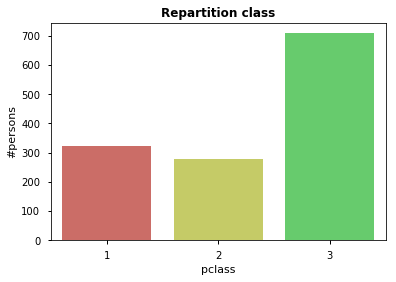

In [198]:
nice_bar_plot(df['pclass'], 'Repartition class', '#persons')

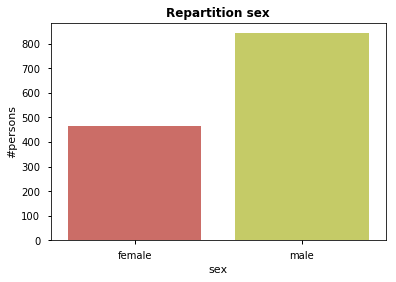

In [199]:
nice_bar_plot(df['sex'], 'Repartition sex', '#persons')

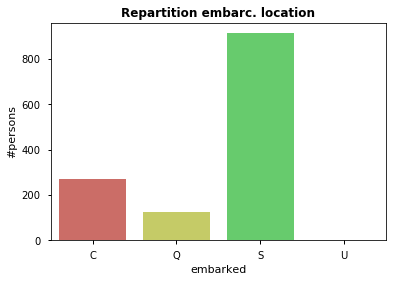

In [208]:
nice_bar_plot(df['embarked'], 'Repartition embarc. location', '#persons')

In [209]:
# age